In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle

In [6]:
np.random.seed(100)

In [7]:
# ChatGPT
# n is the number of samples to be generated
# low_D and high_D are, respectively, the lower and upper bounds for the domain of the samples
# m, q are the linear function parameters
# X, Y: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)
def linearBinaryClass(n, low_D, high_D, m, q):
    # X = n rows and two columns or features and filled by zeros
    X = np.zeros((n,2))
    # Y = n rows and one column and filled by zeros
    Y = np.zeros((n))
    # To fulfill two columns with random values
    for i in range(2):
        # Filling each column of X with random values between low_D and high_D
        X[:,i] = np.random.uniform(low_D, high_D, size=n)
        
    # Assigning labels to samples based on a linear function
    # If the difference between the second column and (m * first column + q) is greater than 0, assign label 1
    # X[:,0] * m + q) => Y = mX + b
    # This selects the rows in `Y` where the computed difference is greater than 0.
    Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
    #`Y==0`: This creates a boolean array of the same shape as `Y` where elements equal to 0 in `Y` are marked as `True`.
    # `Y[Y==0]`: This selects the elements in `Y` where the condition `Y==0` is `True`.
    Y[Y==0] = -1
    return X,Y 

In [8]:
# 10 Samples, in [-5,5] range, with linear function slope m=2 and constant b=10
# 10 rows and 2 columns
X, Y = linearBinaryClass(10, -5, 5, 2, 10)

In [9]:
X

array([[ 0.43404942,  3.91321954],
       [-2.21630615, -2.90797878],
       [-0.75482409, -3.1467178 ],
       [ 3.44776132, -3.9162311 ],
       [-4.95281144, -2.80302507],
       [-3.78430879,  4.78623785],
       [ 1.70749085,  3.11683149],
       [ 3.25852755, -3.28058987],
       [-3.6329341 ,  3.16224749],
       [ 0.75093329, -2.25926253]])

In [10]:
Y

array([-1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1.])

In [11]:
# Euclidean distance calculation
# This function, `euclidDistance`, computes the Euclidean distance between two points `P1` and `P2`. 
# The Euclidean distance is a measure of the straight-line distance between two points in Euclidean space.
def euclideanDistance(P1, P2):
    # Why return key word hasn't been specified :( numerous time was taken to explore the issue
    return np.linalg.norm(P1-P2,2)

In [12]:
# - The function returns the matrix `D` containing all the computed
# Euclidean distances between points in `X1` and `X2`.
# Xte=X1 - Ypred, Xtr=X2 - Ytr
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
		# row = idx1 
    for idx1 in range(len(X1)):
				# column = idx2
        for idx2 in range(len(X2)):
						# Between train and test in order to explore appropirate label or y
            D[idx1,idx2] = euclideanDistance(X1[idx1,:],X2[idx2,:])
	# allDistances
    ''' print("allDistances \n")
    print("X1 Train: {0} \n".format(X1))
    print("X2 Test: {0} \n".format(X2))
    print("D \n: {0}".format(D)) '''
    return D

In [13]:
def flipLabels(Y, P):
    # Check if the percentage P is within the valid range (0 to 100)
    if P < 1 or P > 100:
        print("P should be a percentage value between 0 and 100.")
        return -1

    # Check if all values in Y are either +1 or -1
    if any(np.abs(Y) != 1):
        print("The values of Y should be +1 or -1.")
        return -1

    # Create a copy of the label array Y and ensure it is one-dimensional
    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1: # The number of dimensions
        print("Please supply a label array with only one dimension.")
        return -1

    # Get the size of the label array
    n = Y_noisy.size

    # Calculate the number of label flips based on the percentage P
		# Just a number of flips (to simulate noise)
    n_flips = int(np.floor(n * P / 100))

    # Randomly choose indices to flip without replacement
		# Random number generation from zero to n and n_flips number
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)

    # Flip the selected labels in the copied array
    # Reverse
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    # Return the modified label array
    return Y_noisy

In [14]:
def kNNClassify(Xtr, Ytr, k, Xte):
    # Get the number of training and test samples (by row count)
    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    # Check if all values in Ytr are either +1 or -1
    if any(np.abs(Ytr) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    # If k is greater than the number of training points, set k=n_train
    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    # Initialize an array to store the predicted labels for the test samples
    Ypred = np.zeros(n_test)

    # Compute the pairwise distances between test and training samples
    dist = allDistances(Xte, Xtr)

    # Iterate over each test sample
    for idx in range(n_test):
        # Find the indices of the k-nearest neighbors for the current test sample
        # Sort based on the distance
        # k is the number of neighbors
        # [:k] means column zero to k
        # np.argsort = Perform an indirect sort along the given axis using
        # the algorithm specified by the kind keyword. It returns an array
        # of indices of the same shape as a that index data along the given
        # axis in sorted order.
        # This code executed in order to sort the dist(distance), then based on sort
        # the first ones would be useful for KNN algorithm in terms of minimum distance
        # Finally, k spcifies how many neighbors should be taken, for instance k=2
        # means 0,1 the first and second one.
        neigh_indexes = np.argsort(dist[idx, :])[:k]
        # Instead of using for or while loop, this line is able to accomplish in array
        # format, therefore, the range should be specified. 
        # Dist[idx, :][:k] → the first part [idx, :], it embarks on idx index to the
        # end and [:k], k has been placed after colon means from index zero to k.
				

        # Compute the average label of the k-nearest neighbors
        avg_neigh = np.mean(Ytr[neigh_indexes])

        # Assign the sign of the average label as the predicted label for the current
				# test sample
        Ypred[idx] = np.sign(avg_neigh)

    # Return the array of predicted labels for the test samples
    return Ypred

In [15]:
# My Code
# Lest split our data

# linearBinaryClass(n, low_D, high_D, m, q)
# n is the number of samples to be generated
# low_D and high_D are, respectively, the lower and upper bounds for the domain of the samples
# m, q are the linear function parameters
# X, Y: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)
# 20 Samples, in [-5,5] range, with linear function slope m=2 and constant b=10
# 20 rows and 2 columns

# Random Data Generation
X,Y = linearBinaryClass(20, -30, 50, 2, 10)

# My Code
# Lest split our data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=101)

In [16]:
X_train

array([[-21.58818517,  -1.23937249],
       [-15.9671637 , -13.19787379],
       [ 33.65300068,  -7.12834477],
       [  0.5554756 ,  17.90871567],
       [-28.7796023 ,  38.19160703],
       [ 41.23292508,  -2.78478277],
       [ 16.15211995,  10.43451437],
       [-29.54491941,  31.52921369],
       [-25.20464089, -10.98446331],
       [ 18.30436312,  40.78826348]])

In [17]:
X_test

array([[ -3.11104399, -28.36486944],
       [ -9.80589172,  -9.94438167],
       [ 35.4119503 ,  16.54737539],
       [ 45.20238557,  20.41471492],
       [ 17.90747015,  48.00051949],
       [ 48.47366856, -15.75352084],
       [-27.08191547,  -1.61635107],
       [ 41.24367558, -26.4110174 ],
       [  4.53633469,  29.39837513],
       [ -0.1734363 ,  13.57479025]])

In [18]:
y_train

array([ 1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.])

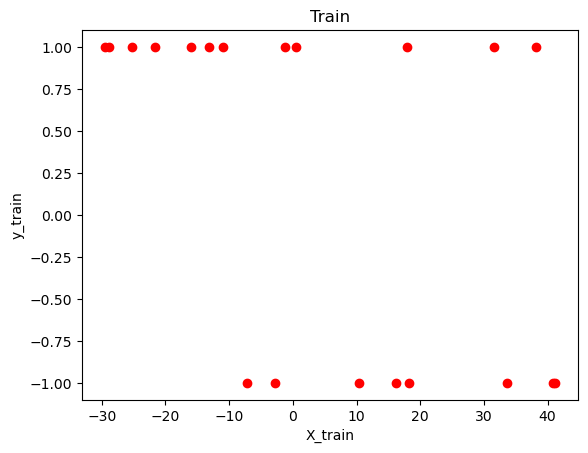

In [19]:
# Visualization
fig, ax = plt.subplots()
ax.set_title('Train')
ax.set_xlabel('X_train')
ax.set_ylabel('y_train')
ax.plot(X_train, y_train,'ro')

In [20]:
k = 1
# kNNClassify(Xtr, Ytr, k, Xte):
# Split = X_train, X_test, y_train, y_test
y_pred = kNNClassify(X_train, y_train, k, X_test)

In [21]:
y_pred

array([ 1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  1.])

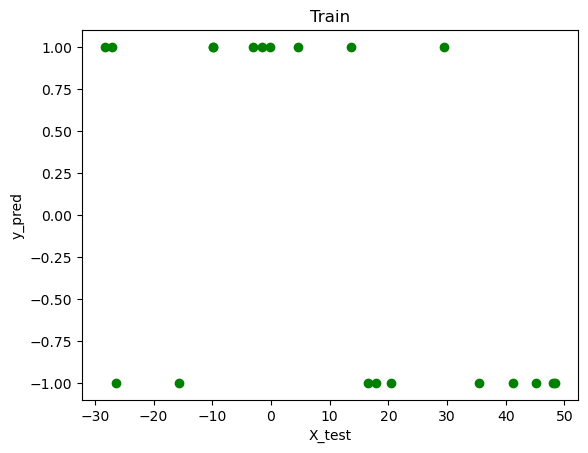

In [22]:
# Visualization
fig, ax = plt.subplots()
ax.set_title('Train')
ax.set_xlabel('X_test')
ax.set_ylabel('y_pred')
ax.plot(X_test, y_pred,'go')

In [23]:
def separatingFkNN(Xtr, Ytr, k):
    # Use the kNNClassify function to obtain predicted labels for the training data
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xtr)

    print('Xtr: {0}'.format(Xtr))
    # Extract the x and y coordinates from the training data
    x = Xtr[:, 0]
    print('x = Xtr[:, 0]: {0}'.format(x))
    y = Xtr[:, 1]
    print('y = Xtr[:, 1]: {0}'.format(y))

    print('Ypred: {0}'.format(Ypred))

    # Create a grid for visualization
    xi = np.linspace(x.min(), x.max(), 200)
    # print('xi: {0}'.format(xi))
    yi = np.linspace(y.min(), y.max(), 200)
    # print('yi: {0}'.format(yi))
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')
    # print('zi: {0}'.format(zi))

    # Create a new plot
    plt.subplots()

    # Plot contours of the separating function
		# Line
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])

    # # Plot data points with colors representing their true labels
		# Point
    plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)

    # Set plot limits
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())

    # Set the title of the plot
    msg = 'Separating function, k=' + str(k)
    plt.title(msg)

    # Show the plot
    plt.show()

In [24]:
def calcAccuracy(Ypred, Ytrue):
    # To check how many cells aren't empty with condition which predicted_y equals
    # to the real_y
    return (np.count_nonzero(Ypred == Ytrue)) / len(Ytrue)

def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [25]:
# Mine
accuracy = calcAccuracy(y_pred, y_train)
error= calcError(y_pred, y_train)

Xtr: [[-2.47495091e+00 -6.18327908e+00]
 [ 1.85610802e+00  4.12039040e+00]
 [ 2.59883751e+00 -5.18734358e+00]
 [-7.14799371e+00  7.02648854e+00]
 [ 8.67682599e+00  6.48204579e+00]
 [ 8.92759762e+00  5.04235732e-01]
 [ 2.04593315e+00 -2.27318411e+00]
 [-2.24467439e+00  1.81761581e+00]
 [-2.73623992e+00 -7.24952770e+00]
 [-5.91309446e+00  6.16540816e+00]
 [-4.46469877e+00  9.31651630e+00]
 [-5.06928238e+00  5.59591608e+00]
 [-6.52783997e+00 -5.21329836e+00]
 [ 9.33219389e+00  7.34520826e+00]
 [ 9.14025201e+00  6.16230026e+00]
 [ 1.95947369e+00 -8.72637752e+00]
 [ 4.62601506e+00 -5.37543392e+00]
 [-3.19229554e+00  1.79370897e+00]
 [-8.15888793e+00 -7.25026104e+00]
 [-7.30039621e-01  3.56881409e+00]
 [ 1.73977865e-01  9.84381379e+00]
 [-8.23079654e+00 -4.28496030e+00]
 [ 5.60704466e-01  5.21825519e+00]
 [ 9.84316073e+00 -9.06945665e+00]
 [-2.09928136e+00 -3.34928187e+00]
 [-3.28807117e+00  8.89105582e+00]
 [ 6.10901075e+00  2.73034083e+00]
 [ 5.08697989e+00  2.03697212e+00]
 [-3.73867117e+

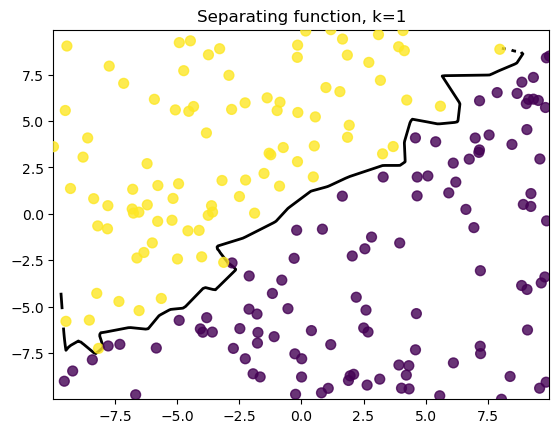

With K=1 the accuracy on the test set is  0.96
With K=1 the accuracy on the training set is  1.0


In [26]:
# Professor code execution
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

# n is the number of samples to be generated
# low_D and high_D are, respectively, the lower and upper bounds for the domain of the samples
# m, q are the linear function parameters
# X, Y: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)

# Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

# Visualize the separating curve for the NN classifier 
separatingFkNN(Xtr, Ytr, k)

# Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

# Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

# Compute the accuracy on the TEST SET
acc = calcAccuracy(Ypred, Yte)

print("With K=%d the accuracy on the test set is " % (k), acc)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
acctr = calcAccuracy(Ypredtr, Ytr)
print("With K=%d the accuracy on the training set is " % (k), acctr)


Cross Validation for KNN (Various K for KNN)

In [28]:
# Compute the test error for different values of K
# kNNClassify(Xtr, Ytr, k, Xte)

def trainTestAnalysis(k_list, Xtr, Ytr, Xte, Yte):
    # Initialize arrays to store training and testing errors for different values
		# of k
    train_err = np.zeros(len(k_list))
    test_err = np.zeros(len(k_list))

    # Iterate over the list of k values
    for kdx, k in enumerate(k_list):
        # enm = enumerate([3, 5, 7, 9])
        # >>> print(list(enm))
        # [(0, 3), (1, 5), (2, 7), (3, 9)]	=> kdx is the index and k is the value
				# Use kNNClassify to get predictions for the test set for each k
        Ypredte = kNNClassify(Xtr, Ytr, k, Xte)
        # Calculate and store the testing error
        test_err[kdx] = calcError(Ypredte, Yte)
        
				# This line of code is misunderstandable, the model is created by X_train
				# Then the performance would be evaluated by X_test
				# It doesn't make sense to compute train and test on the same dataset
				# This line should be considered just for overfitting concept and teaching goal
        # Use kNNClassify to get predictions for the training set
        Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
        # Calculate and store the training error
        train_err[kdx] = calcError(Ypredtr, Ytr)

    # Return the arrays of training and testing errors for analysis
    return train_err, test_err

KFold

In [ ]:
def KFoldCVkNN(Xtr, Ytr, KF, k_list):
    # The goal is to test various k (k_list) on different fold or groups (KF)
			# for this purpose, a matrix[k_list_number][kf] is required
    # Check if the number of repetitions is positive
		# KF = number of folds or groups
    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    print('KF: {0}'.format(KF)) # KF = Number of folds of groups

    # Ensure that k_list is a numpy array
    k_list = np.array(k_list) 
    num_k = k_list.size 
    print('k_list: {0}'.format(k_list)) # k_list = [3, 5, 7, 9]
    print('num_k: {0}'.format(num_k)) # k_list Number = 4
    print('The Number Of Groups or Folds: {0}, k list (various k values): {1}'.format(KF, k_list)) # k_list Number = 4
    # KF = 5

    # Get the total number of samples and calculate the number of samples
			# in each validation fold
    n_tot = Xtr.shape[0] 
    n_val = int(n_tot // KF)
    print('n_tot: {0}'.format(n_tot)) # 200
    print('n_val: {0}'.format(n_val)) # 200/5 = 40

    # Initialize arrays to store training and validation errors for each k
			# and each fold
    # Each k (from k list) is analyzed on each group or fold (5 groups)
    tr_errors = np.zeros((num_k, KF)) # ((4 , 5))
    val_errors = np.zeros((num_k, KF)) # ((4 , 5))
    print('tr_errors: {0}'.format(tr_errors))
    print('val_errors: {0}'.format(val_errors))

    # Loop over each value of k in the provided list
    for kdx, k in enumerate(k_list): # k_list = [3, 5, 7, 9]
        # enm = enumerate([3, 5, 7, 9])
        # >>> print(list(enm))
        # [(0, 3), (1, 5), (2, 7), (3, 9)]	=> kdx is the index and k is the value
        # Randomly shuffle the indices to create random folds
        # n_tot = 200
        # Generates a random sample from a given 1-D array
        # np.random.choice(5, 3)
        # array([0, 3, 4]) # random
        # Random Index
        # This code generates numbers by n_tot=200 and to the number of n_tot=200
        # Array of random indexies with n_tot numbers 
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
				
        # The array of random indexies is divided by KF=5 (5 categories)
        split_idx = np.array_split(rand_idx, KF)
        
        # Loop over each fold
        # 0 to 5
        # in each group or category or better to call it fold 
        for fold in range(KF):
            # Set up boolean masks to separate training and validation sets
            # Only the current fold (for instance in first execuation, is zero)
            # Would be true or 1 (with any number except zero) and others are false
            # or zero
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True
            # split_idx[fold] => val_mask[split_idx[0]] => split_idx[0] is the first element of a whole array split_idx
            # which is a group or fold of indexies of the first group => val_mask[split_idx[0]] means in val_mask all
            # the indexies of split_idx[0] should be true or 1 => instead of using a loop this way is used
            '''
            >>> val_mask[split_idx[0]]
                array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
                        True,  True,  True,  True,  True,  True,  True,  True,  True,
                        True,  True,  True,  True,  True,  True,  True,  True,  True,
                        True,  True,  True,  True,  True,  True,  True,  True,  True,
                        True,  True,  True,  True])
            >>> val_mask[split_idx[1]]
                array([False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False])

            '''

            # Create training and validation sets based on the boolean masks
            # ~ means not 
            # Not val_mask placed in X, Y means all the elements of the arrays 
            # which are not true (just false) that should be consisdred for training set
            # in contrast for test just the val_mask is used (means just the elements which are true).
            # Training Set = The false Section (4/5) KF = 5
            # Test Set = The True Section (1/5) KF = 5
            # 4/5 for model training and 1/5 for model test
            X = Xtr[~val_mask]
            Y = Ytr[~val_mask]
            X_val = Xtr[val_mask]
            Y_val = Ytr[val_mask]
            
            # Compute the training error of the kNN classifier for the given value of k
            # def calcError(Ypred, Ytrue)
            # [(0, 3), (1, 5), (2, 7), (3, 9)]
            # kdx is the index and k is the value
            # kdx is constant for full fold iteration[0-4 or 5 groups] actually for 
            # various k is  used for each fold or group to find out the best one
            tr_errors[kdx, fold] = calcError(kNNClassify(X, Y, k, X), Y)

            # Compute the validation error of the kNN classifier for the given value of k
            val_errors[kdx, fold] = calcError(kNNClassify(X, Y, k, X_val), Y_val)
						
            print('tr_errors: {0}'.format(tr_errors))
            print('val_errors: {0}'.format(val_errors))
						
    # Calculate error statistics along the repetitions
    # Train
    tr_mean = np.mean(tr_errors, axis=1)
    print('tr_mean: {0}'.format(tr_mean))
    tr_var = np.var(tr_errors, axis=1)
    print('tr_var: {0}'.format(tr_var))
    # Test
    val_mean = np.mean(val_errors, axis=1)
    print('val_mean: {0}'.format(val_mean))
    val_var = np.var(val_errors, axis=1)
    print('val_var: {0}'.format(val_var))

    # Find the index of the k with the lowest validation mean error
    best_k_idx = np.argmin(val_mean)
    best_k = k_list[best_k_idx]

    # Return the best k, validation mean and variance, training mean and variance
    return best_k, val_mean, val_var, tr_mean, tr_var

In [31]:
# KFoldCVkNN(Xtr, Ytr, KF, k_list)
# Assuming you have your training data (Xtr, Ytr)
# Xtr: Your feature matrix, Ytr: Your target labels

# Set the number of folds (KF) and the list of k values to be evaluated
KF = 5
k_list = [3, 5, 7, 9]

# Assuming Xtr and Ytr are defined
# They have been defined in profossor's execution codes

# Call KFoldCVkNN function
best_k, val_mean, val_var, tr_mean, tr_var = KFoldCVkNN(Xtr, Ytr, KF, k_list)

# Display the results or use them for further analysis
print("Best k:", best_k)
print("Validation Mean Error:", val_mean)
print("Validation Variance:", val_var)
print("Training Mean Error:", tr_mean)
print("Training Variance:", tr_var)

KF: 5
k_list: [3 5 7 9]
num_k: 4
The Number Of Groups or Folds: 5, k list (various k values): [3 5 7 9]
n_tot: 200
n_val: 40
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
tr_errors: [[0.0125 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]]
val_errors: [[0.075 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
tr_errors: [[0.0125 0.0125 0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]]
val_errors: [[0.075 0.075 0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
tr_errors: [[0.0125 0.0125 0.025  0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 

In [30]:
def KFoldCVkNN(Xtr, Ytr, KF, k_list):
    # The goal is to test various k (k_list) on different fold or groups (KF)
			# in order to find out the best one
			# for this purpose, a matrix[k_list_number][kf] is required
    # Check if the number of repetitions is positive
		# KF = number of folds or groups
    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    print('KF: {0}'.format(KF)) # KF = Number of folds of groups

    # Ensure that k_list is a numpy array
    k_list = np.array(k_list) 
    num_k = k_list.size 
    print('k_list: {0}'.format(k_list)) # k_list = [3, 5, 7, 9]
    print('num_k: {0}'.format(num_k)) # k_list Number = 4
    print('The Number Of Groups or Folds: {0}, k list (various k values): {1}'.format(KF, k_list)) # k_list Number = 4
    # KF = 5

    # Get the total number of samples and calculate the number of samples
			# in each validation fold
    n_tot = Xtr.shape[0] 
    n_val = int(n_tot // KF)
    print('n_tot: {0}'.format(n_tot)) # 200
    print('n_val: {0}'.format(n_val)) # 200/5 = 40

    # Initialize arrays to store training and validation errors for each k
			# and each fold
    # Each k (from k list) is analyzed on each group or fold (5 groups)
    tr_errors = np.zeros((num_k, KF)) # ((4 , 5))
    val_errors = np.zeros((num_k, KF)) # ((4 , 5))
    print('tr_errors: {0}'.format(tr_errors))
    print('val_errors: {0}'.format(val_errors))

    # Loop over each value of k in the provided list
    for kdx, k in enumerate(k_list): # k_list = [3, 5, 7, 9]
        # enm = enumerate([3, 5, 7, 9])
        # >>> print(list(enm))
        # [(0, 3), (1, 5), (2, 7), (3, 9)]	=> kdx is the index and k is the value
        # Randomly shuffle the indices to create random folds
        # n_tot = 200
        # Generates a random sample from a given 1-D array
        # np.random.choice(5, 3)
        # array([0, 3, 4]) # random
        # Random Index
        # This code generates numbers by n_tot=200 and to the number of n_tot=200
        # Array of random indexies with n_tot numbers 
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
				
        # The array of random indexies is divided by KF=5 (5 categories)
        split_idx = np.array_split(rand_idx, KF)
        
        # Loop over each fold
        # 0 to 5
        # in each group or category or better to call it fold 
        for fold in range(KF):
            # Set up boolean masks to separate training and validation sets
            # Only the current fold (for instance in first execuation, is zero)
            # Would be true or 1 (with any number except zero) and others are false
            # or zero
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True
            # split_idx[fold] => val_mask[split_idx[0]] => split_idx[0] is the first element of a whole array split_idx
            # which is a group or fold of indexies of the first group => val_mask[split_idx[0]] means in val_mask all
            # the indexies of split_idx[0] should be true or 1 => instead of using a loop this way is used
            '''
            >>> val_mask[split_idx[0]]
                array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
                        True,  True,  True,  True,  True,  True,  True,  True,  True,
                        True,  True,  True,  True,  True,  True,  True,  True,  True,
                        True,  True,  True,  True,  True,  True,  True,  True,  True,
                        True,  True,  True,  True])
            >>> val_mask[split_idx[1]]
                array([False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False, False, False, False, False, False,
                       False, False, False, False])

            '''

            # Create training and validation sets based on the boolean masks
            # ~ means not 
            # Not val_mask placed in X, Y means all the elements of the arrays 
            # which are not true (just false) that should be consisdred for training set
            # in contrast for test just the val_mask is used (means just the elements which are true).
            # Training Set = The false Section (4/5) KF = 5
            # Test Set = The True Section (1/5) KF = 5
            # 4/5 for model training and 1/5 for model test
            X = Xtr[~val_mask]
            Y = Ytr[~val_mask]
            X_val = Xtr[val_mask]
            Y_val = Ytr[val_mask]
            
            # Compute the training error of the kNN classifier for the given value of k
            # def calcError(Ypred, Ytrue)
            # [(0, 3), (1, 5), (2, 7), (3, 9)]
            # kdx is the index and k is the value
            # kdx is constant for full fold iteration[0-4 or 5 groups] actually for 
            # various k is  used for each fold or group to find out the best one
            tr_errors[kdx, fold] = calcError(kNNClassify(X, Y, k, X), Y)

            # Compute the validation error of the kNN classifier for the given value of k
            val_errors[kdx, fold] = calcError(kNNClassify(X, Y, k, X_val), Y_val)
						
            print('tr_errors: {0}'.format(tr_errors))
            print('val_errors: {0}'.format(val_errors))
						
    # Calculate error statistics along the repetitions
    # Training set 
    tr_mean = np.mean(tr_errors, axis=1)
    print('tr_mean: {0}'.format(tr_mean))
    tr_var = np.var(tr_errors, axis=1)
    print('tr_var: {0}'.format(tr_var))
    # Test set
    val_mean = np.mean(val_errors, axis=1)
    print('val_mean: {0}'.format(val_mean))
    val_var = np.var(val_errors, axis=1)
    print('val_var: {0}'.format(val_var))

    # Find the index of the k with the lowest validation mean error
		# For each one, k is calculated 
    best_k_idx = np.argmin(val_mean)
    best_k = k_list[best_k_idx]

    # Return the best k, validation mean and variance, training mean and variance
    return best_k, val_mean, val_var, tr_mean, tr_var

In [ ]:
# Explore the best K value
with open("Training1.dat","rb") as f:
    [Xtr, Ytr] = pickle.load(f)
with open("Test1.dat","rb") as f:
    [Xte, Yte] = pickle.load(f)

In [35]:
def plot_knn_errors(k_list, val_mean, val_var, tr_mean, tr_var):
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()
		
    # Plot=layout the mean validation error with error bars representing the variance
		# x axis = k_list, y axis = val_mean, val_var = error
    ax.errorbar(k_list, val_mean, val_var, label="Validation error")

    # Plot the mean training error with error bars representing the variance
		# x axis = k_list, y axis = tr_mean, tr_var = error
    ax.errorbar(k_list, tr_mean, tr_var, label="Training error")

    # Set the x-axis to show only integer labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  

    # Add a legend to the plot
    ax.legend(loc="best")

    # Set labels for the y-axis and x-axis
    ax.set_ylabel("Error (misclassified fraction)")
    ax.set_xlabel("K")

KF: 5
k_list: [1 2 3]
num_k: 3
The Number Of Groups or Folds: 5, k list (various k values): [1 2 3]
n_tot: 200
n_val: 40
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0.05  0.025 0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0.05  0.025 0.05  0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0.05  0.025 0.05  0.025 0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]]
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [

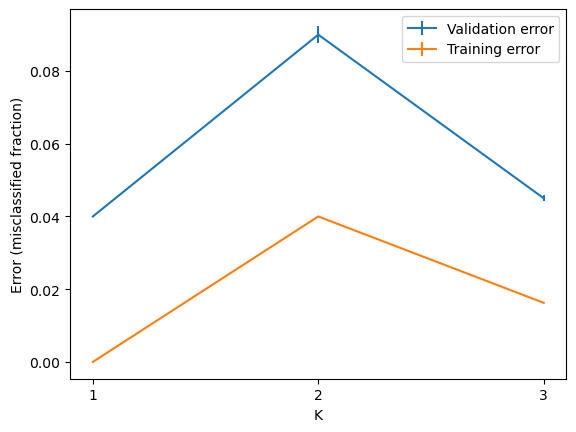

In [36]:
k_list = [1, 2, 3]
best_k, val_err, val_var, tr_err, tr_var = KFoldCVkNN(Xtr, Ytr, 5, k_list)
plot_knn_errors(k_list, val_err, val_var, tr_err, tr_var)

KF: 5
k_list: [ 1  3  5  7  9 11 13]
num_k: 7
The Number Of Groups or Folds: 5, k list (various k values): [ 1  3  5  7  9 11 13]
n_tot: 200
n_val: 40
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
tr_errors: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
val_errors: [[0.05  0.025 0.    0.    0.   ]
 [0.    0.    0.    0.    0.   ]
 [0.    0

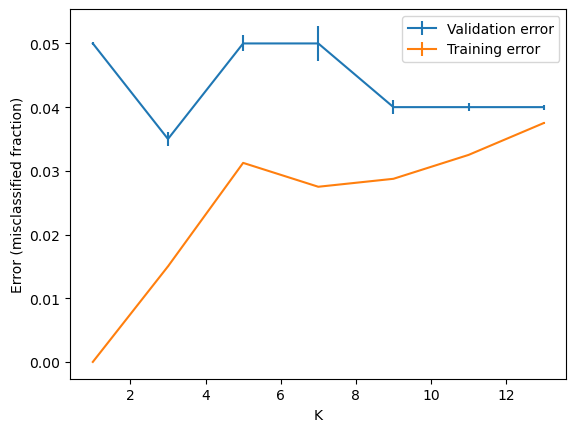

In [37]:
k_list = np.arange(1, 15, 2)
best_k, val_err, val_var, tr_err, tr_var = KFoldCVkNN(Xtr, Ytr, 5, k_list)
plot_knn_errors(k_list, val_err, val_var, tr_err, tr_var)

In [38]:
[train_err, test_err] = trainTestAnalysis(np.arange(1, 15, 2), Xtr, Ytr, Xte, Yte)

Text(0.5, 0, 'K')

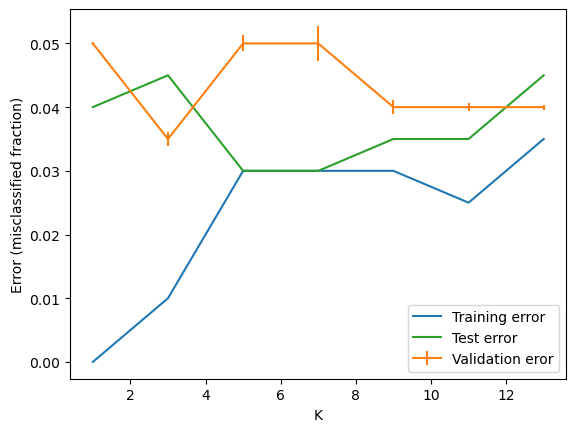

In [39]:
# Let's plot training, test and validation errors in the same plot

fig, ax = plt.subplots()
# x=k_list, y=train_error
ax.plot(k_list, train_err, label="Training error")
# x=k_list, y=val_err
ax.errorbar(k_list, val_err, val_var, label="Validation eror")
# x=k_list, y=test_err
ax.plot(k_list, test_err, label="Test error")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Only show integer labels on x-axis
ax.legend(loc="best")
ax.set_ylabel("Error (misclassified fraction)")
ax.set_xlabel("K")